均线：前N天的移动平均值

日均线：5天 10天
季均线：30天 60天
年均线：120天 240天

金叉：短期均线上穿长期均线，买入信号
死叉：短期均线下穿

In [82]:
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [83]:
stock_record = ak.stock_zh_a_hist(symbol='000001', start_date='20150101', adjust='hfq').iloc[:, :5]
stock_record.columns = ['date', 'open', 'close', 'high', 'low']
# 指定列索引，要重新赋值。如果是从csv文件读取，默认第一列是index
stock_record = stock_record.set_index('date')

In [84]:
# stock_record['ma5'] = np.nan
# ma_day = 5
# for i in range(4, len(stock_record)):
#   stock_record.loc[stock_record.index[i], 'ma5'] = stock_record['close'][i - 4: i + 1].mean()
# rolling
stock_record['ma5'] = stock_record['close'].rolling(5).mean()
stock_record['ma30'] = stock_record['close'].rolling(30).mean()
# mpl finace包， mav函数可以直接

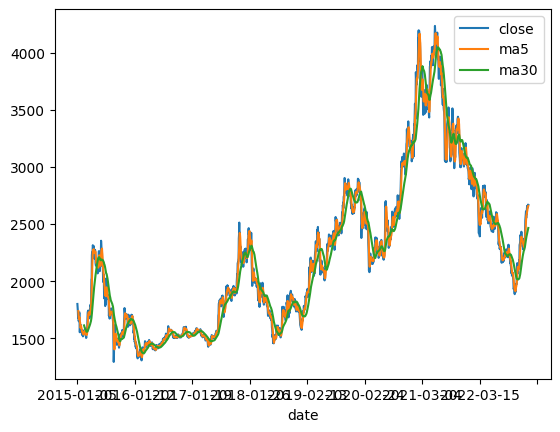

In [85]:
stock_record[['close', 'ma5', 'ma30']].plot()
plt.show()

In [86]:
stock_record = stock_record.dropna()

# 叉
sr1 = stock_record['ma5'] > stock_record['ma30']
sr2 = stock_record['ma5'] <= stock_record['ma30']

# 死叉
death_cross = stock_record[sr1 & sr2.shift(1)].index

# 金叉
golden_cross = stock_record[-(sr1 | sr2.shift(1))].index

In [87]:
# stock_record['cross'] = np.nan
# for i in range(0, len(stock_record)):
#   date = stock_record.index[i]
#   is_gold = date in golden_cross
#   is_death = date in death_cross
#   if is_gold:
#     stock_record.loc[date, 'cross'] = 1
#   elif is_death:
#     stock_record.loc[date, 'cross'] = -1
# stock_record = stock_record.dropna()

golden_crosses = pd.Series(1, index=golden_cross)
death_crosses = pd.Series(-1, index=death_cross)
crosses = pd.concat([golden_crosses, death_crosses]).sort_index() # 旧版 sr1.append(sr2)

In [88]:
origin = 10000000

cash = origin
hold = 0

# for i in range(0, len(stock_record)):
#   date = stock_record.index[i]
#   cross = stock_record.loc[date]['cross']
#   close = stock_record.loc[date]['close']
#   if cross > 0:
#     buy = int(cash / close)
#     cash -= buy * close
#     hold += buy
#   else:
#     sell = hold * close
#     hold = 0
#     cash -= sell

# 1手100股！！！！
for i in range(0, len(crosses)):
  open_price = stock_record['close'][crosses.index[i]]
  if crosses.iloc[i] == 1:
    buy = (cash // (100 * open_price))
    cash -= buy * 100 * open_price
    hold += buy * 100
  else:
    cash -= hold * open_price
    hold = 0

# 可能手上还持有
# 最后一天的price
price = stock_record['close'][-1]
hold_value = price * hold
rate = (cash + hold_value - origin) / origin
rate

-0.06329690000000038

1. 实际上策略算金叉和死叉的时候，只能用开盘，因为做策略的时候，是看不到收盘价的。
收盘价算金叉死叉->开盘卖，赚很多，开盘算，就很少了
因为用收盘，其实是预计到了后面的信息，做的判读
2. 23333后面股价太高，一开始数值太小了股票买不起1手了

In [89]:
# 后面一天开盘买卖？
origin = 10000000
cash = origin
hold = 0

for i in range(0, len(crosses)):
  date_index = crosses.index[i]
  next_index_in_stock = stock_record.index.get_loc(date_index) + 1
  if (next_index_in_stock < len(stock_record)):
    open_price = stock_record['open'][next_index_in_stock]
    if crosses.iloc[i] == 1:
      buy = (cash // (100 * open_price))
      cash -= buy * 100 * open_price
      hold += buy * 100
    else:
      cash -= hold * open_price
      hold = 0
  
price = stock_record['close'][-1]
hold_value = price * hold
rate = (cash + hold_value - origin) / origin
rate

0.31629870000000077